<a href="https://colab.research.google.com/github/mto0501/facial_recognition/blob/main/Facial_recognition_Hang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import display, Image
import matplotlib.image as mpimg
import pathlib
from pathlib import Path
import zipfile
from zipfile import ZipFile
import glob 
import os
import os, tarfile
import shutil
#import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_dir = pathlib.Path('/content/gdrive/MyDrive/ML_PROJECTS/portrait_group3')

image_count = len(list(data_dir.glob('*/*.jpg'))) ###
print(image_count)

512


In [ ]:
# all in one go
all_image_labels = [label_to_index[label]
                    for label in all_labels]

print("First 5 labels indices: ", all_image_labels[:5])
print("First 5 paths: ")
all_image_paths[:5]

NameError: ignored

Data organizing:


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset= "training",
  labels = 'inferred',
  label_mode = 'categorical',
  seed=42,
  image_size=(224, 224),
  batch_size=32)

Found 512 files belonging to 5 classes.
Using 410 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  labels = 'inferred',
  label_mode = 'categorical',
  seed=42,
  image_size=(224, 224),
  batch_size=32)

Found 512 files belonging to 5 classes.
Using 102 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Duc_Anh', 'Hang', 'Hoi', 'Ngoc', 'Yen']


visualize a random image before augmentation:

In [ ]:
images, labels = next(iter(train_ds.take(1)))
image = images[1].numpy().astype("uint8")
plt.imshow(image)
plt.show()

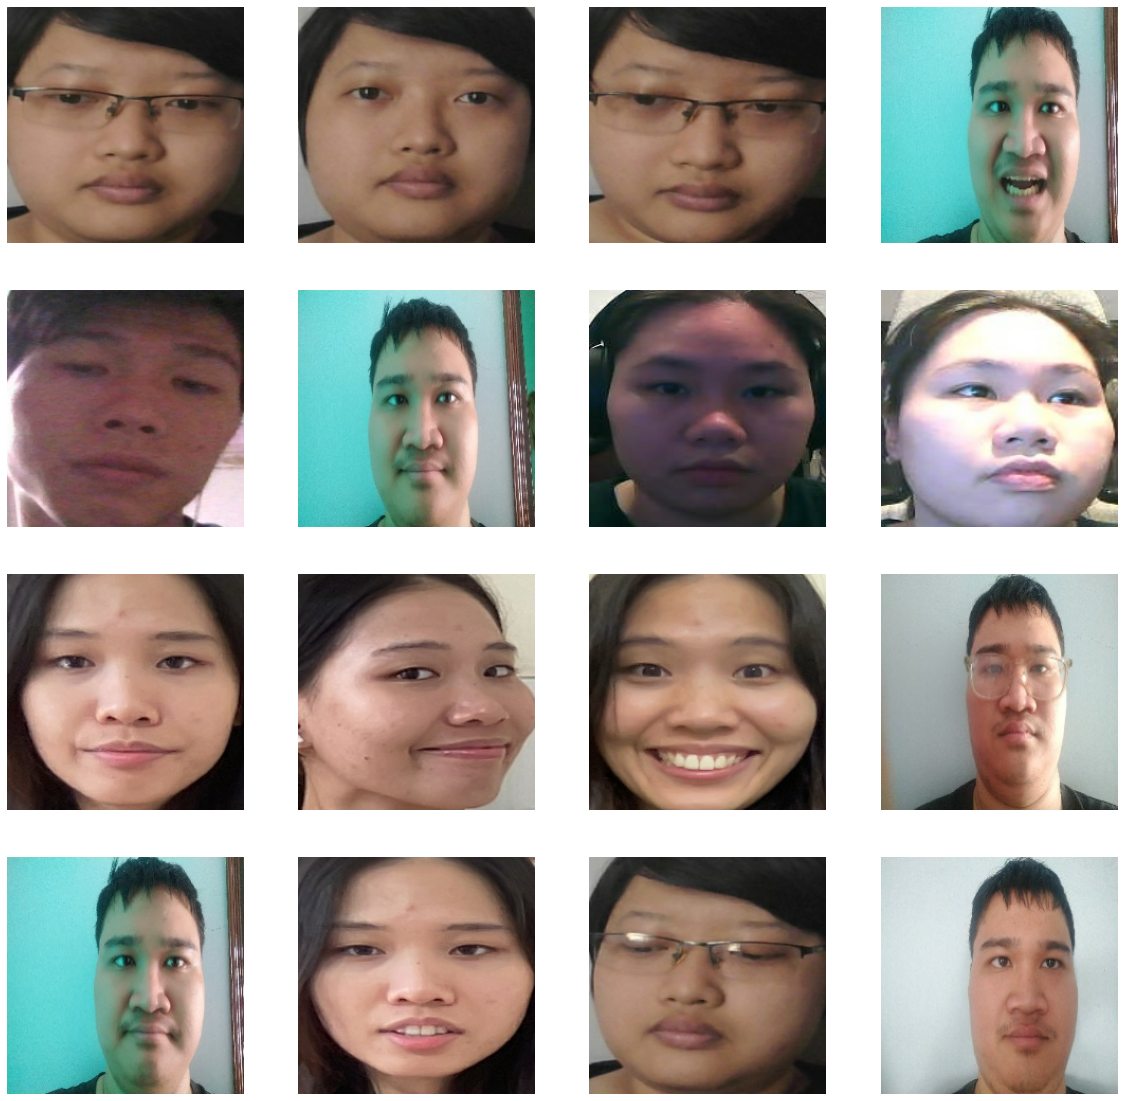

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
#   print(labels)
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

Prepare ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 299
BATCH_SIZE = 32

def generator_augmentation_maker():
  train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2)     # IMPORTANT
  
  val_gen = ImageDataGenerator(validation_split=0.2)  # IMPORTANT

  train_generator = train_gen.flow_from_directory(
          data_dir,  
          target_size=(IMG_SIZE,IMG_SIZE),  
          batch_size=32,
          class_mode='categorical',
          shuffle=True,
          seed=42,            # IMPORTANT
          subset='training')  # IMPORTANT

  validation_generator = val_gen.flow_from_directory(
          data_dir,
          target_size=(IMG_SIZE,IMG_SIZE),
          batch_size=32,
          class_mode='categorical',
          shuffle=False,        # IMPORTANT
          seed=42,              # IMPORTANT
          subset='validation')  # IMPORTANT
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = generator_augmentation_maker()

Found 411 images belonging to 5 classes.
Found 101 images belonging to 5 classes.


In [ ]:
base_model = keras.applications.Xception(
                          weights="imagenet",
                          input_shape=(299, 299, 3), 
                          include_top=False)

base_model.trainable=False

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
from keras.applications.xception import preprocess_input

def model_maker():
  inputs = keras.Input(shape=(299,299,3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(5, activation='softmax')(x)
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
model = model_maker()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 

callback = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)]

init_epochs=5

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=init_epochs,
                    callbacks = callback)

Epoch 1/5
17/17 [==============================] - 118s 6s/step - loss: 1.3572 - accuracy: 0.4181 - val_loss: 1.0466 - val_accuracy: 0.8092 - lr: 0.0010
Epoch 2/5
17/17 [==============================] - 12s 694ms/step - loss: 0.8272 - accuracy: 0.8644 - val_loss: 0.7256 - val_accuracy: 0.9695 - lr: 0.0010
Epoch 3/5
17/17 [==============================] - 11s 672ms/step - loss: 0.5485 - accuracy: 0.9586 - val_loss: 0.5543 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 4/5
17/17 [==============================] - 11s 673ms/step - loss: 0.4060 - accuracy: 0.9831 - val_loss: 0.4295 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 5/5
17/17 [==============================] - 12s 674ms/step - loss: 0.3095 - accuracy: 0.9793 - val_loss: 0.3462 - val_accuracy: 0.9924 - lr: 0.0010


In [ ]:
model.evaluate(validation_generator)

5/5 [==============================] - 1s 112ms/step - loss: 0.3462 - accuracy: 0.9924


[0.34616872668266296, 0.9923664331436157]

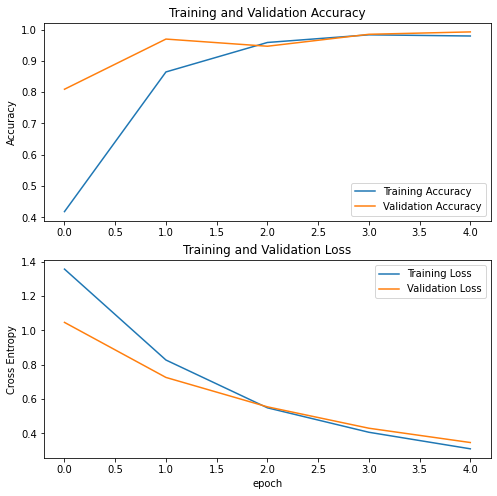

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Tuning:

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [ ]:
# Unfreeze the base_model.
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 127

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # default 0.001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/ML_PROJECTS/Results_face"
!mkdir -p "/content/gdrive/MyDrive/ML_PROJECTS/Results_face"
RESULT           =  pathlib.Path("/content/gdrive/MyDrive/ML_PROJECTS/Results_face")
SAVED_MODEL     =  pathlib.Path("/content/gdrive/MyDrive/ML_PROJECTS/Results_face")

In [ ]:
# CALLBACK and TRAIN

# Stopped by EarlyStopping: model is auto-restored best weights => can CONTINUE to finetune
# Stopped by user => LOAD model_ckpt to continue
# Stopped by finishing => model saved to Saved_model

from keras.callbacks import ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
             ModelCheckpoint(monitor='val_loss', filepath=RESULT/'model_ckptface.h5', save_weights_only=False, save_best_only=True, verbose=1)]

init_epochs = 5
fine_tune_epochs = 20
total_epochs = init_epochs + fine_tune_epochs

history_fine = model.fit(train_generator, 
                         validation_data=validation_generator,
                         epochs=total_epochs,
                         initial_epoch=init_epochs,
                         callbacks=callbacks)

model.save(SAVED_MODEL)

Epoch 6/25
17/17 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.9831
Epoch 00006: val_loss improved from inf to 0.32146, saving model to /content/gdrive/MyDrive/ML_PROJECTS/Results_face/model_ckptface.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


17/17 [==============================] - 16s 737ms/step - loss: 0.2602 - accuracy: 0.9831 - val_loss: 0.3215 - val_accuracy: 0.9924
Epoch 7/25
17/17 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.9887
Epoch 00007: val_loss improved from 0.32146 to 0.29688, saving model to /content/gdrive/MyDrive/ML_PROJECTS/Results_face/model_ckptface.h5
17/17 [==============================] - 13s 788ms/step - loss: 0.2473 - accuracy: 0.9887 - val_loss: 0.2969 - val_accuracy: 0.9924
Epoch 8/25
17/17 [==============================] - ETA: 0s - loss: 0.2195 - accuracy: 0.9868
Epoch 00008: val_loss improved from 0.29688 to 0.27751, saving model to /content/gdrive/MyDrive/ML_PROJECTS/Results_face/model_ckptface.h5
17/17 [==============================] - 13s 776ms/step - loss: 0.2195 - accuracy: 0.9868 - val_loss: 0.2775 - val_accuracy: 0.9924
Epoch 9/25
17/17 [==============================] - ETA: 0s - loss: 0.2034 - accuracy: 0.9887
Epoch 00009: val_loss improved from 0.27751 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
model.evaluate(validation_generator)

5/5 [==============================] - 1s 112ms/step - loss: 0.0947 - accuracy: 1.0000


[0.09471738338470459, 1.0]

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

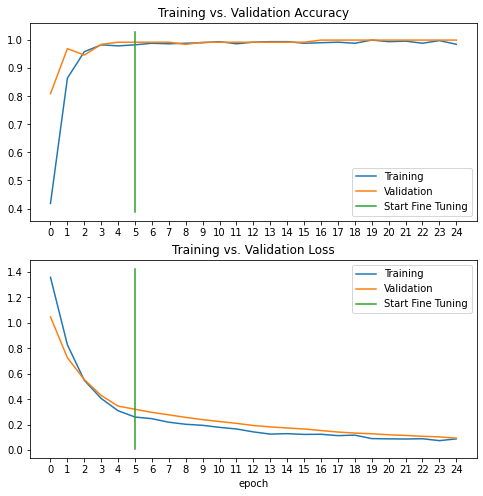

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0.9, 1])
plt.plot([init_epochs,init_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training vs. Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([init_epochs,init_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training vs. Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from google.colab import files
# UPLOAD A PHOTO and PREDICT
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  img_path = './' + fn

Saving 260951153_194047189591348_6301676825051229639_n.jpg to 260951153_194047189591348_6301676825051229639_n.jpg
260951153_194047189591348_6301676825051229639_n.jpg


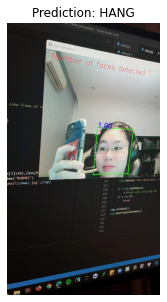

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

img        = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array  = image.img_to_array(img)
img_array  = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

for key, value in validation_generator.class_indices.items():
  if value == prediction[0].argmax(): # argmax -> index
    pred = key

plt.figure(figsize=(5,5))
img = mpimg.imread(img_path)
plt.imshow(img)
plt.title('Prediction: ' + pred.upper()) #label predicted
plt.axis('off')
plt.grid(b=None)
plt.show()

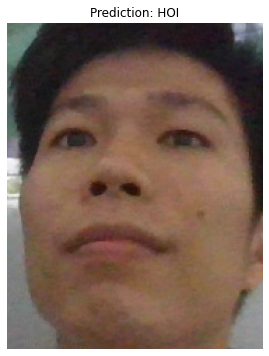

True

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

def predict(model, image_path, img_size):
  img = image.load_img(image_path, target_size=(img_size, img_size))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  prediction = model.predict(img)

  for key, value in validation_generator.class_indices.items():
    if value == prediction[0].argmax():
      pred = key

  plt.figure(figsize=(9, 6))
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.title('Prediction: ' + pred.upper())
  plt.grid(b=None)
  plt.axis('off')
  plt.show()

  return True

# YOUR FILE HERE
image_path= '/content/gdrive/MyDrive/ML_PROJECTS/portrait_group3/Hoi/194534.jpg'
predict(model, image_path, IMG_SIZE)

In [ ]:
validation_generator.class_indices

{'Duc_Anh': 0, 'Hang': 1, 'Hoi': 2, 'Ngoc': 3, 'Yen': 4}

In [ ]:
ground_truth = validation_generator.classes
filenames = validation_generator.filenames

In [ ]:
predictions = model.predict(validation_generator)
pred_indices = np.argmax(predictions,axis=1)

img_paths = list(map(lambda x: str(data_dir/x), filenames))  # Full path

In [ ]:
ground_truth[:5] , img_paths[:5]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(ground_truth, pred_indices, target_names=list(validation_generator.class_indices.keys())))

              precision    recall  f1-score   support

     Duc_Anh       1.00      1.00      1.00        22
        Hang       1.00      1.00      1.00        46
         Hoi       1.00      1.00      1.00        22
        Ngoc       1.00      1.00      1.00        20
         Yen       1.00      1.00      1.00        21

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131



In [ ]:
print(validation_generator.class_indices)

{'Duc_Anh': 0, 'Hang': 1, 'Hoi': 2, 'Ngoc': 3, 'Yen': 4}


In [ ]:
filenames = validation_generator.filenames
#print(len(filenames))
#print(filenames[500:505], '\n')

ground_truth = validation_generator.classes
#print(len(ground_truth))
ground_truth

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
      dtype=int32)

In [ ]:
predictions = model.predict(validation_generator)

In [ ]:
predictions[:10]

array([[9.5325339e-01, 2.8774203e-03, 3.5452526e-02, 7.1260282e-03,
        1.2906381e-03],
       [9.5471686e-01, 1.9230682e-03, 3.3269271e-02, 8.9069279e-03,
        1.1839130e-03],
       [9.4977236e-01, 3.3631288e-03, 3.9414130e-02, 6.3955225e-03,
        1.0549251e-03],
       [9.3919671e-01, 2.2555417e-03, 5.2857559e-02, 4.9023791e-03,
        7.8775181e-04],
       [9.5548773e-01, 1.6692702e-03, 3.2421242e-02, 9.6516935e-03,
        7.7008229e-04],
       [8.9230180e-01, 3.7810518e-03, 9.0971105e-02, 1.1543494e-02,
        1.4025398e-03],
       [9.3660676e-01, 1.9428905e-03, 4.2300332e-02, 1.8079264e-02,
        1.0707423e-03],
       [9.1703153e-01, 4.9973479e-03, 5.9460770e-02, 1.6618403e-02,
        1.8919412e-03],
       [8.4186995e-01, 4.2532026e-03, 1.3930884e-01, 1.3085895e-02,
        1.4821221e-03],
       [9.2094016e-01, 3.0673202e-03, 6.6648357e-02, 8.2619172e-03,
        1.0822668e-03]], dtype=float32)

In [ ]:
# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    # get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability, 
                               index_of_highest_probability, 
                               ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)


In [ ]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        similar_image_paths.append(str(data_dir) + '/' + filenames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

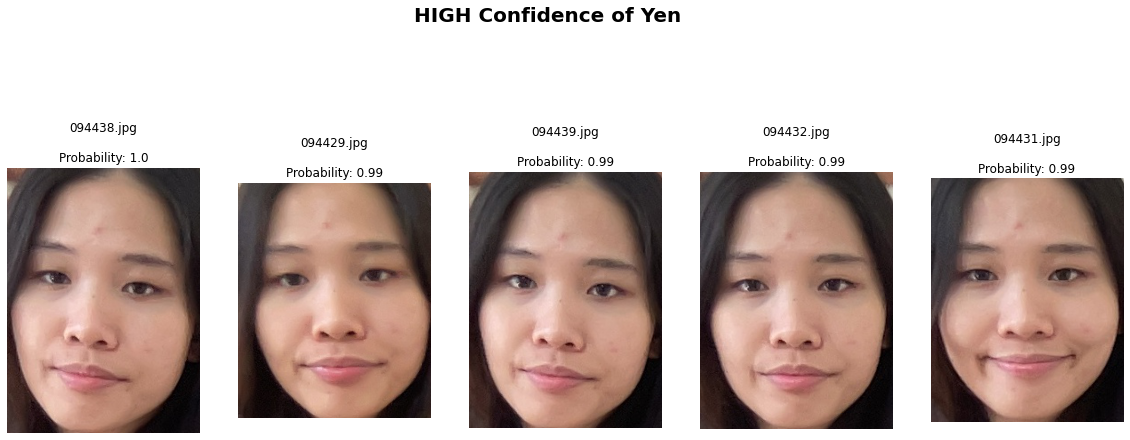

In [ ]:
message = 'HIGH Confidence of Yen'
highest_confident_yen_images = get_images_with_sorted_probabilities(prediction_table, True, 4, 5, False)
display(highest_confident_yen_images, message) 

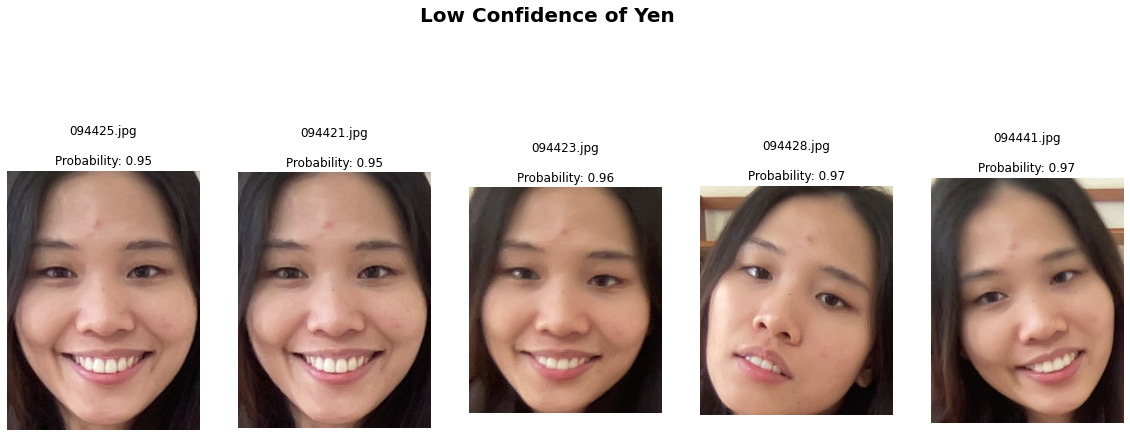

In [ ]:
message = 'Low Confidence of Yen'
low_confident_yen_images = get_images_with_sorted_probabilities(prediction_table, False, 4, 5, False)
display(low_confident_yen_images, message) 

Restore model trained

In [ ]:
restore_model = tf.keras.models.load_model("/content/gdrive/MyDrive/ML_PROJECTS/Results_face")
# Show the model architecture
restore_model.summary()
restore_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
loss, acc = restore_model.evaluate(validation_generator)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

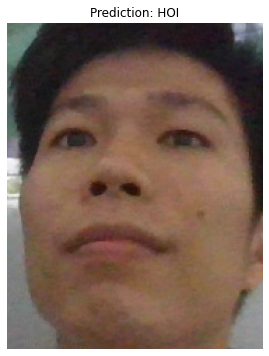

True

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

def predict(model, image_path, img_size):
  img = image.load_img(image_path, target_size=(img_size, img_size))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  prediction = model.predict(img)

  for key, value in validation_generator.class_indices.items():
    if value == prediction[0].argmax():
      pred = key

  plt.figure(figsize=(9, 6))
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.title('Prediction: ' + pred.upper())
  plt.grid(b=None)
  plt.axis('off')
  plt.show()

  return True

# YOUR FILE HERE
image_path= '/content/gdrive/MyDrive/ML_PROJECTS/portrait_group3/Hoi/194534.jpg'
predict(restore_model, image_path, IMG_SIZE)